## Training GAT network for finding bike traffic patterns

In [1]:
import mlflow

# Specify tracking server
mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.set_experiment("Predict bike traffic_GAT_fixed_floor_area")

<Experiment: artifact_location='mlflow-artifacts:/797981034638231270', creation_time=1725170517251, experiment_id='797981034638231270', last_update_time=1725170517251, lifecycle_stage='active', name='Predict bike traffic_GAT_fixed_floor_area', tags={}>

In [2]:
import os

os.environ['USE_PYGEOS'] = '0'
import datetime
from enum import Enum
from pathlib import Path

import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx
import numpy as np
import torch
from matplotlib.animation import FuncAnimation
from shapely import LineString
# from tqdm import tqdm
from tqdm.notebook import tqdm
from torch_geometric.utils.convert import from_networkx
# from torch_geometric.transforms import NormalizeScale

from utils.config import SIGNATURE


class OptimizerType(Enum):
    ADAM = {
        "learning_rate": 0.005,
        "betas": (0.9, 0.999),
        "eps": 1e-08,
        "weight_decay": 0.001,
    }
    SGD = {
        "learning_rate": 0.0001,
        "momentum": 0.8,
        "weight_decay": 0.0001,
    }


params = {
    "train_ratio": 0.8,
    "num_hidden_channels": 16,
    "GNN_dropout_rate": 0.1,
    "head_num": 8,
    "optimizer": OptimizerType.ADAM,  # or OptimizerType.SGD
    "num_layers": 4,
    "batch_size": 64,
    #  the learning rate of each parameter group using a cosine annealing schedule
    "scheduler": False
    # "scheduler_gamma": [0.8],
    # "pos_weight": [1.3],
    # "model_embedding_size": [64],
    # "model_attention_heads": [3],
    # "model_layers": [4],
    # "model_dropout_rate": [0.2],
    # "model_top_k_ratio": [0.5],
    # "model_top_k_every_n": [1],
    # "model_dense_neurons": [256]
}

In [3]:
prefix_name = "testF4mean"
place_name = "Dresden"
file_name = place_name + "_" + prefix_name

len_normalize = 100

data_path = Path().resolve() / "data" / "processed" / f"{file_name}.gpkg"
traffic = gpd.read_file(data_path, driver='GPKG', layer='traffic')
print(f"loading data from {data_path}")

# traffic.crs = "epsg:4326"
traffic = traffic.to_crs(4839)
# traffic.crs = "epsg:3857"

loaded_graph = momepy.gdf_to_nx(traffic, approach="primal")
nodes = max(nx.connected_components(loaded_graph), key=len)
connected_graph = nx.subgraph(loaded_graph, nodes)
connected_graph = nx.Graph(connected_graph)
# H_nodes, H_edges = momepy.nx_to_gdf(H)
# print(H_edges.head(12))

num_idx_graph = nx.convert_node_labels_to_integers(
    connected_graph, label_attribute="coordinate")
node_loc = {
    i: num_idx_graph.nodes[i]["coordinate"]
    for i in range(num_idx_graph.number_of_nodes())
}

lineGraph = nx.line_graph(num_idx_graph)
# for node in lineGraph.copy():
#     lineGraph.add_node(node,mm_len=num_idx_graph.edges[node]["mm_len"]/len_normalize,
#                 occurrence=num_idx_graph.edges[node]["occurrence"],
#                 bikeability=num_idx_graph.edges[node]["bikeability"]
#                 )

attr_list = [
    "mm_len", "occurrence", "bikeability", "floor_area", "department_store",
    "supermarket", "kiosk", "variety_store", "foodstore", "bakery",
    "ice_cream", "bookstore", "ticket", "copyshop", "fashion", "DIY",
    "houseware", "furniture", "electronics", "sportstore", "florist",
    "laundry", "petstore", "toystore", "cafe", "restaurant", "pub", "theatre",
    "cinema", "market", "place_of_worship", "bank", "pharmacy", "chemist",
    "post_office", "townhall", "library", "kindergarten", "school", "college",
    "park", "stadium", "sportplace", "university"
]
attr_list_no_occurrence = [
    "mm_len", "bikeability", "floor_area", "department_store", "supermarket",
    "kiosk", "variety_store", "foodstore", "bakery", "ice_cream", "bookstore",
    "ticket", "copyshop", "fashion", "DIY", "houseware", "furniture",
    "electronics", "sportstore", "florist", "laundry", "petstore", "toystore",
    "cafe", "restaurant", "pub", "theatre", "cinema", "market",
    "place_of_worship", "bank", "pharmacy", "chemist", "post_office",
    "townhall", "library", "kindergarten", "school", "college", "park",
    "stadium", "sportplace", "university"
]
for node in lineGraph.copy():
    attr_dict = {
        attr_name: num_idx_graph.edges[node][attr_name]
        for attr_name in attr_list
    }
    lineGraph.add_node(node, **attr_dict)

data = from_networkx(lineGraph, group_node_attrs=attr_list_no_occurrence)
data.x[:, 0] = data.x[:, 0] / len_normalize
# data.x = F.normalize(data.x, dim=0)
# data.x = z_score(data.x)
data.y = data.occurrence.unsqueeze(1)
del data.occurrence
# data = transform(data)
# type(pyg_graph)
print(data)
# print(nx.number_of_edges(lineGraph))
# L2.edges
# print(pyg_graph.num_nodes)


ERROR 1: PROJ: proj_create_from_database: Open of /data/horse/ws/chou-env/geo-bike/share/proj failed


loading data from /data/horse/ws/chou-app/bike_prediction/data/processed/Dresden_testF4mean.gpkg
Data(edge_index=[2, 55050], x=[12912, 43], y=[12912, 1])


In [4]:
# Draw the traffic flow in designated areas

# _, gdf_edges = momepy.nx_to_gdf(connected_graph)
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# gdf_edges.plot(column="occurrence",
#                ax=ax,
#                legend=True,
#                legend_kwds={"shrink": 0.5},
#                norm=colors.LogNorm(vmin=1, vmax=gdf_edges["occurrence"].max()))
# ax.set_axis_off()

# fig_path = Path().resolve() / "data" / "image"
# fig_path.mkdir(parents=True, exist_ok=True)
# plt.savefig(fig_path / f"{file_name}.svg", format="svg")


In [5]:
# find histogram of features
# idx = 0
# test = data.x[:,idx]
# plt.hist(test,bins=20,range=(0, 5))
# print(attr_list_no_occurrence[idx])
# print(max(test))


In [6]:
# gdf_edges.explore()

Split the data to trains and test sets

In [7]:
now = datetime.datetime.now()
time_tag = now.strftime("%m%d_%H%M")

data.train_mask = torch.rand(data.num_nodes) < params["train_ratio"]
data.test_mask = ~data.train_mask
mask_path = Path().resolve() / "data" / "mask"
mask_path.mkdir(parents=True, exist_ok=True)
np.save(mask_path / f"{file_name}_{time_tag}.npy", data.train_mask)

In [8]:
from torch.nn import Linear, MSELoss
import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv, TopKPooling


# Define the GAT model
class GAT(torch.nn.Module):

    def __init__(self, num_features, num_layers, hidden_channels, heads,
                 dropout):
        super(GAT, self).__init__()

        self.dropout = dropout
        # GNN layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(num_features, hidden_channels,
                                  heads))  # First layer

        for _ in range(1, num_layers - 1):  # Middle layers
            self.convs.append(
                GATConv(hidden_channels * heads, hidden_channels, heads))

        self.convs.append(
            GATConv(hidden_channels * heads,
                    hidden_channels,
                    heads=1,
                    concat=False))  # Last layer

        # linear layers
        self.linear1 = Linear(hidden_channels, 24)
        self.linear2 = Linear(24, 24)
        self.linear3 = Linear(24, 1)

    def forward(self, x, edge_index):
        # Iterate over GNN layers
        for _, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # linear layer
        x = self.linear1(x)
        x = F.elu(x)
        x = self.linear2(x)
        x = F.elu(x)
        x = self.linear3(x)
        return x


model = GAT(data.num_features, params["num_layers"],
            params["num_hidden_channels"], params["head_num"],
            params["GNN_dropout_rate"])
print(model)
# print(f"Number of parameters: {count_parameters(model)}")

GAT(
  (convs): ModuleList(
    (0): GATConv(43, 16, heads=8)
    (1-2): 2 x GATConv(128, 16, heads=8)
    (3): GATConv(128, 16, heads=1)
  )
  (linear1): Linear(in_features=16, out_features=24, bias=True)
  (linear2): Linear(in_features=24, out_features=24, bias=True)
  (linear3): Linear(in_features=24, out_features=1, bias=True)
)


In [9]:
from torch_geometric.loader import ClusterData, ClusterLoader

torch.manual_seed(12345)
cluster_data = ClusterData(data, num_parts=512)  # 1. Create subgraphs. 128
train_loader = ClusterLoader(
    cluster_data, batch_size=params["batch_size"],
    shuffle=True)  # 2. Stochastic partioning scheme. 32

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...



Step 1:
Number of nodes in the current batch: 1620
Data(x=[1620, 43], y=[1620, 1], train_mask=[1620], test_mask=[1620], edge_index=[2, 4854])

Step 2:
Number of nodes in the current batch: 1614
Data(x=[1614, 43], y=[1614, 1], train_mask=[1614], test_mask=[1614], edge_index=[2, 4666])

Step 3:
Number of nodes in the current batch: 1615
Data(x=[1615, 43], y=[1615, 1], train_mask=[1615], test_mask=[1615], edge_index=[2, 4686])

Step 4:
Number of nodes in the current batch: 1609
Data(x=[1609, 43], y=[1609, 1], train_mask=[1609], test_mask=[1609], edge_index=[2, 4960])

Step 5:
Number of nodes in the current batch: 1616
Data(x=[1616, 43], y=[1616, 1], train_mask=[1616], test_mask=[1616], edge_index=[2, 4500])

Step 6:
Number of nodes in the current batch: 1608
Data(x=[1608, 43], y=[1608, 1], train_mask=[1608], test_mask=[1608], edge_index=[2, 4758])

Step 7:
Number of nodes in the current batch: 1615
Data(x=[1615, 43], y=[1615, 1], train_mask=[1615], test_mask=[1615], edge_index=[2, 4652])

Done!


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train():
    model.train()
    running_loss = 0.0
    step = 0

    for sub_data in train_loader:  # Iterate over each mini-batch.

        sub_data = sub_data.to(device)
        optimizer.zero_grad()
        out = model(sub_data.x, sub_data.edge_index)

        # Only use nodes with labels available for loss calculation --> mask
        loss = criterion(out[sub_data.train_mask],
                         sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step += 1

    return running_loss / step


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # rmse = RMSE(data.y[data.test_mask], out[data.test_mask])
    loss = criterion(out[data.test_mask], data.y[data.test_mask])
    return loss


# Function to create a frame for the animation
def create_frame(epoch):
    plt.figure(figsize=(6, 6))

    prediction = model(data.x, data.edge_index)
    truth = data.y.detach().numpy()
    prediction = prediction.detach().numpy()
    pair_predict = np.concatenate((truth, prediction), axis=1)

    max_ground_value = max(data.y.detach().numpy())
    mask = data.train_mask.numpy()

    plt.plot(pair_predict[mask, 0],
             pair_predict[mask, 1],
             'o',
             color='royalblue',
             markersize=2,
             label='train data')
    plt.plot(pair_predict[~mask, 0],
             pair_predict[~mask, 1],
             'o',
             color='indianred',
             markersize=2,
             label='test data')

    plt.text(0.05,
             0.95,
             f'Epoch: {epoch:04d}',
             transform=plt.gca().transAxes,
             fontsize='medium',
             verticalalignment='top')
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.xlim([0, max_ground_value])
    plt.ylim([0, max_ground_value])
    plt.legend(loc='upper left')

    return plt.gca().figure,


# Create the animation
def create_animation(max_epoch):
    fig, ax = plt.subplots(figsize=(6, 6))
    ani = FuncAnimation(fig,
                        create_frame,
                        frames=range(max_epoch),
                        repeat=False)

    # Save the animation
    # animation_path = output_path / f"{file_name}_{time_tag}.mp4"
    animation_path = Path().resolve() / "data" / "anima"
    animation_path.mkdir(parents=True, exist_ok=True)
    ani.save(animation_path / f"{file_name}_{time_tag}.gif",
             writer='ffmpeg',
             fps=5)

    plt.close(fig)


def animation():
    animation_count = 0
    max_groud_value = max(data.y.detach().numpy())
    mask = data.train_mask.numpy()
    prediction = model(data.x, data.edge_index)
    truth = data.y.detach().numpy()
    prediction = prediction.detach().numpy()
    pair_predict = np.concatenate((truth, prediction), axis=1)

    animation_path = Path().resolve()/"data"/"anima"/\
            f"{file_name}_{time_tag}_{animation_count:03d}.png"

    scatter1 = plt.plot(pair_predict[mask.transpose().ravel(), 0],
                        pair_predict[mask.transpose().ravel(), 1],
                        'o',
                        color='royalblue',
                        markersize=2,
                        label='train data')
    scateer2 = plt.plot(pair_predict[~mask.transpose().ravel(), 0],
                        pair_predict[~mask.transpose().ravel(), 1],
                        'o',
                        color='indianred',
                        markersize=2,
                        label='test data')

    plt.text(-300, -300, f'epoch: {epoch:04d}', fontsize='medium')
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.xlim([0, max_groud_value])
    plt.ylim([0, max_groud_value])
    plt.legend(loc='upper left')
    plt.savefig(animation_path, format="png", dpi=200)
    plt.close()

    animation_count += 1


Setting up Adam optimizer with lr: 0.005, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


Train:   0%|          | 0/2000 [00:00<?, ? step/s]

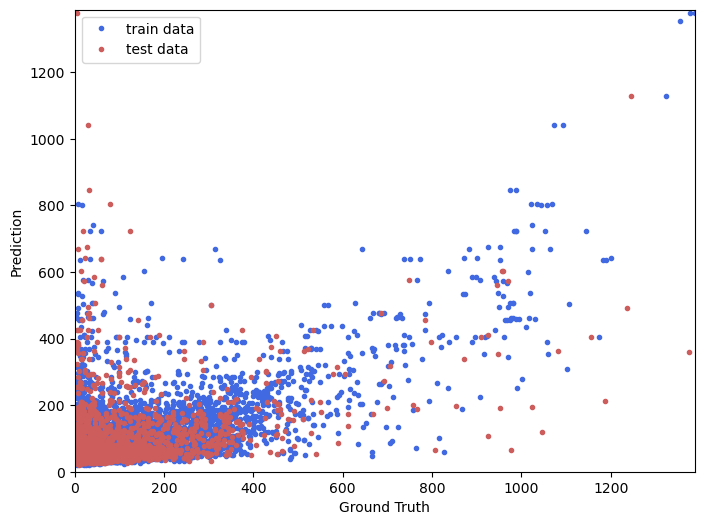

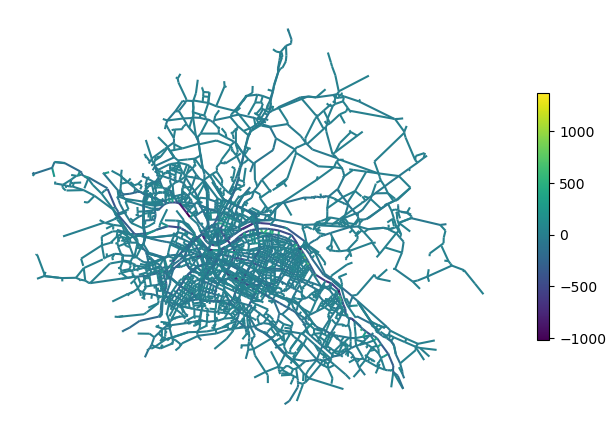

2024/09/26 14:50:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-fox-701 at: http://localhost:5000/#/experiments/797981034638231270/runs/e1150b014b6e4e6ca6840b7dc5898008.
2024/09/26 14:50:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/797981034638231270.


In [11]:
# train parameters
max_epoch = 2000
max_early_stopping_counter = 500
# best_train_loss = 100000
best_test_loss = 100000
nocheck_until = 3000
early_stopping_counter = 0
# animation setting
animatiing_results = False

# Use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
optimizer_type = params["optimizer"]
optimizer_config = optimizer_type.value

if params["optimizer"] == OptimizerType.ADAM:
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=optimizer_config["learning_rate"],
                                 betas=optimizer_config["betas"],
                                 eps=optimizer_config["eps"],
                                 weight_decay=optimizer_config["weight_decay"])
    print(f'Setting up Adam optimizer with '
          f'lr: {optimizer_config["learning_rate"]}, '
          f'betas: {optimizer_config["betas"]}, '
          f'eps: {optimizer_config["eps"]}, '
          f'weight_decay: {optimizer_config["weight_decay"]}')
elif params["optimizer"] == OptimizerType.SGD:
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=optimizer_config["learning_rate"],
                                momentum=optimizer_config["momentum"],
                                weight_decay=optimizer_config["weight_decay"])
    print(f'Setting up SGD optimizer with '
          f'lr: {optimizer_config["learning_rate"]}, '
          f'momentum: {optimizer_config["momentum"]}, '
          f'weight_decay: {optimizer_config["weight_decay"]}')

if params["scheduler"] == True:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max=500,
                                                           eta_min=0.000001)

# Define loss function
criterion = MSELoss()

# train_losses = []
# test_losses = []

with mlflow.start_run() as run:

    mlflow.log_param("dataset", file_name)
    mlflow.log_param("num_params", count_parameters(model))
    # mlflow.log_artifact(fig_path)
    mlflow.log_artifact(mask_path / f"{file_name}_{time_tag}.npy")

    # Log the general parameters
    for key in params:
        if key != "optimizer":  # Exclude logging the optimizer enum object directly
            mlflow.log_param(key, params[key])

    # Log the optimizer type
    mlflow.log_param("optimizer_type", optimizer_type.name)

    # Log each parameter within the optimizer config
    for key, value in optimizer_config.items():
        mlflow.log_param(f"{optimizer_type.name.lower()}_{key}", value)

    # progress_bar = tqdm(max_epoch, desc=f"train epoch", leave=False)
    progress_bar = tqdm(total=max_epoch, desc="Train", unit=" step", position=0, leave=True)

    try:
        for epoch in range(max_epoch):
            if early_stopping_counter <= max_early_stopping_counter:
                #train
                train_loss = np.sqrt(train())
                mlflow.log_metric(key="Train loss",
                                  value=float(train_loss),
                                  step=epoch)

                #test
                test_loss = torch.sqrt(test())
                mlflow.log_metric(key="Test loss",
                                  value=float(test_loss),
                                  step=epoch)

                # progress display
                progress_bar.update(1)
                progress_bar.set_postfix({
                    "train loss": f"{train_loss:.2f}",
                    "test loss": f"{test_loss:.2f}"
                })
                # if epoch > nocheck_until: #do not check early_stopping after some epochs
                #       if float(test_loss) < best_test_loss:
                #             best_loss = test_loss
                #             early_stopping_counter = 0
                #             # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)

                #       if float(train_loss) < best_train_loss:
                #             best_loss = train_loss
                #             early_stopping_counter = 0
                #             mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                #       else:
                #             early_stopping_counter += 1

                # if epoch > nocheck_until: #do not check early_stopping after some epochs
                #       if float(test_loss) < best_loss:
                #             best_loss = test_loss
                #             early_stopping_counter = 0
                #             mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                #       else:
                #             early_stopping_counter += 1

                if epoch > nocheck_until:  #do not check early_stopping after some epochs

                    if float(test_loss) < best_test_loss:
                        best_test_loss = test_loss
                        mlflow.pytorch.log_model(model,
                                                 "model",
                                                 signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                # scheduler.step()
            else:
                print("Early stopping due to no improvement.")
                break

            # if epoch % 200 == 0:
            #     print(
            #         f"Epoch: {epoch:03d}, Train Loss: {train_loss:.1f}, Test Loss: {test_loss:.1f}"
            #     )

            # if epoch % 10 == 0 and animatiing_results:
            if animatiing_results:
                create_animation(max_epoch)
                print("Plot one frame")

    finally:
        progress_bar.close()
    # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)

    # plot
    result_path = Path().resolve(
    ) / "data" / "image" / f"{file_name}_{time_tag}.svg"
    result_Emap_path = Path().resolve(
    ) / "data" / "image" / f"{file_name}_{time_tag}_Emap.svg"
    
    prediction = model(data.x, data.edge_index)
    truth = data.y.detach().cpu().numpy()
    prediction = prediction.detach().cpu().numpy()
    error = prediction - truth
    pair_predict = np.concatenate((truth, prediction), axis=1)

    max_ground_value = max(data.y.detach().cpu().numpy())
    mask = data.train_mask.cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.plot(pair_predict[mask, 0],
             pair_predict[mask, 1],
             'o',
             color='royalblue',
             markersize=3,
             label='train data')
    plt.plot(pair_predict[~mask, 0],
             pair_predict[~mask, 1],
             'o',
             color='indianred',
             markersize=3,
             label='test data')

    # plt.plot(pair_predict[:, 0], pair_predict[:, 1], "o", markersize=3)
    # plt.plot(pair_predict[data.test_mask.cpu(), 0],
    #          pair_predict[data.test_mask.cpu(), 1],
    #          "or",
    #          markersize=3)
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.xlim([0, max_ground_value])
    plt.ylim([0, max_ground_value])
    plt.legend(loc='upper left')
    plt.savefig(result_path, format="svg")
    plt.show()

    lines = [
        LineString([node_loc[node[0]], node_loc[node[1]]])
        for node in lineGraph.nodes
    ]
    readout_gdf = gpd.GeoDataFrame({
        "error": error.ravel(),
        "geometry": lines
    },
                                   crs="EPSG:4839")

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    readout_gdf.plot(column="error",
                     ax=ax,
                     legend=True,
                     legend_kwds={"shrink": 0.4},
                    #  norm=colors.LogNorm(vmin=1, vmax=5000)
                     )
    ax.set_axis_off()
    plt.savefig(result_Emap_path, format="svg")
    plt.show()

    mlflow.log_artifact(result_path)
    mlflow.log_artifact(result_Emap_path)

In [ ]:
len(data.x)


In [ ]:
n_bins = 50
bin_range1 = (0, np.max(truth))
bin_range2 = (0, np.max(prediction))
# bin_range2 = (0, 200)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
axes[0].hist(truth, bins=n_bins, range=bin_range1)
axes[0].set_title('Ground truth')
axes[0].set_xlim(left=0)

axes[1].hist(prediction, bins=n_bins, range=bin_range2)
axes[1].set_title('Prediction')
axes[1].set_xlim(left=0)

# plt.xlim(bin_range)
plt.tight_layout()
plt.show()

In [ ]:
# Define number of groups
num_groups = 5
max_value = 1000

pair_predict = np.concatenate((truth, prediction), axis=1)

# Split data into groups based on values of the first element
grouped_data = [
    pair_predict[(pair_predict[:, 0] >= i * max_value / num_groups)
                 & (pair_predict[:, 0] < (i + 1) * max_value / num_groups)]
    for i in range(num_groups)
]

# Plot histograms for each group
fig, axs = plt.subplots(num_groups, 1, figsize=(6, 12), sharex=True)
for i in range(num_groups):
    axs[i].hist(grouped_data[i][:, 1], bins=50)
    axs[i].set_title(
        f'Group {i+1}: {i*1000/num_groups} - {(i+1)*1000/num_groups}')

plt.show()


In [ ]:
plt.plot(pair_predict[:, 0], pair_predict[:, 1], "o", markersize=3)
plt.plot(pair_predict[data.test_mask, 0],
         pair_predict[data.test_mask, 1],
         "or",
         markersize=3)
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.show()

In [ ]:
n_bins = 50
bin_range = (-400, 400)
plt.hist(error, bins=n_bins, range=bin_range)
plt.title('Prediction Error')
plt.xlim(bin_range)
plt.show()